# Startegies for Unbalanced Data

* Get more data. The best solution but not always possible.
* Undersample. Throw out lots of data to match sample size. Not really the best idea, unless you have a lot of data to work with.
* Oversample. Create multiple copies of the rare data. Increase risk of overfitting.
* Data augmentation. Add new feateurs as nonlinear transformations of existing data. Usually feasible for images.
* Create synthetic samples. Can be good if the fake data look like real data. SMOTE: synthetic minority oversampling technique.

# Undersampling and Augmentation

We're going to test 5 different datasets:

1. Original
2. Oversampled fully - we double full dataset
3. Oversampled train - we double only train dataset
4. Oversampled fully with augmentation - we double full augmented dataset
5. Oversampled train with augmentation - we double train augmented dataset

In [28]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

## Data

In [29]:
df = np.loadtxt(open('/content/sample_data/mnist_train_small.csv', 'rb'), delimiter=',')

labels = df[:,0]
data = df[:,1:]

labels = torch.tensor(labels, dtype = torch.long)
data = torch.tensor(data, dtype = torch.float)

data_norm = data / torch.max(data)

labels, data_norm

(tensor([6, 5, 7,  ..., 2, 9, 5]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]))

/tmp/ipython-input-175688169.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  img_aug = img + np.random.random_sample(img.shape)/2


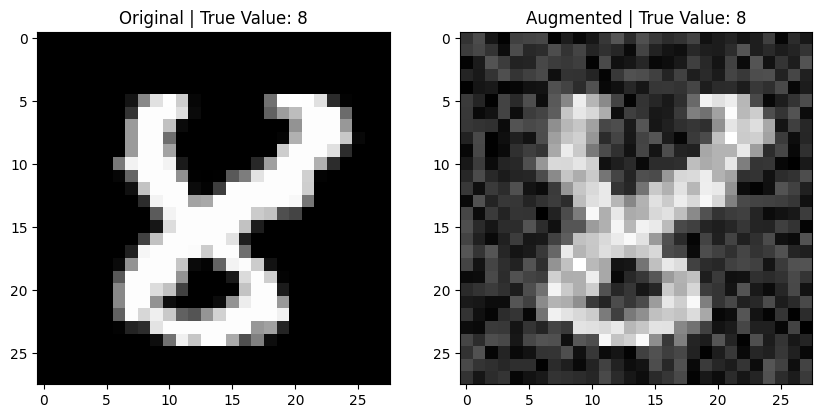

In [54]:
fig, ax = plt.subplots(1,2, figsize = (10, 20))

rand_row = np.random.randint(len(data_norm))
img = np.reshape(data_norm[rand_row], (28,28))
ax[0].imshow(img, cmap = 'grey')
ax[0].set_title(f'Original | True Value: {labels[rand_row]}')

img_aug = img + np.random.random_sample(img.shape)/2
ax[1].imshow(img_aug, cmap='grey')
ax[1].set_title(f'Augmented | True Value: {labels[rand_row]}')
plt.show()

## Create Dataset

In [31]:
def create_data(data, labels, n_samples, double='none', augment=False):
  '''
  n_samples - how many samples are given from original data
  double- full, train
    full - we double all selected samples from original dataset
    train - we double only train dataset
  augment - will augment images with a rango of [0,.5] (half of the image range)
  '''

  if double not in ['full', 'train', 'none']:
    return "Available option = 'train', 'full', 'none'"

  samples = np.random.choice(len(data), size = min(n_samples, len(data)), replace = False)

  new_data = data[samples]
  if augment:
    new_data = new_data + np.random.random_sample(new_data.shape)/2
    new_data = new_data / torch.max(new_data)

  new_labels = labels[samples]

  if double == 'full':
    new_data = np.concatenate((new_data, new_data), axis = 0)
    new_labels = np.concatenate((new_labels, new_labels), axis = 0)

  dataT = torch.tensor(new_data, dtype=torch.float)
  labelsT = torch.tensor(new_labels, dtype=torch.long)

  train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT)

  if double == 'train':
    train_data = torch.cat((train_data, train_data), dim = 0)
    train_labels = torch.cat((train_labels, train_labels), dim = 0)

  train_dataset = TensorDataset(train_data, train_labels)
  test_dataset = TensorDataset(test_data, test_labels)

  train_dataloader = DataLoader(train_dataset, batch_size = 20, shuffle = True, drop_last = True)
  test_dataloader = DataLoader(test_dataset, batch_size = test_data.shape[0])

  return train_dataloader, test_dataloader

In [32]:
train_dataloader, test_dataloader = create_data(data_norm, labels, n_samples = 200, double='full')
train_dataloader.dataset.tensors[0].size(), test_dataloader.dataset.tensors[0].size()

(torch.Size([300, 784]), torch.Size([100, 784]))

In [33]:
train_dataloader, test_dataloader = create_data(data_norm, labels, n_samples = 200, double='train')
train_dataloader.dataset.tensors[0].size(), test_dataloader.dataset.tensors[0].size()

/tmp/ipython-input-3608795686.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataT = torch.tensor(new_data, dtype=torch.float)
/tmp/ipython-input-3608795686.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labelsT = torch.tensor(new_labels, dtype=torch.long)


(torch.Size([300, 784]), torch.Size([50, 784]))

In [34]:
train_dataloader, test_dataloader = create_data(data_norm, labels, n_samples = 200, double='none')
train_dataloader.dataset.tensors[0].size(), test_dataloader.dataset.tensors[0].size()

/tmp/ipython-input-3608795686.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataT = torch.tensor(new_data, dtype=torch.float)
/tmp/ipython-input-3608795686.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labelsT = torch.tensor(new_labels, dtype=torch.long)


(torch.Size([150, 784]), torch.Size([50, 784]))

## Model

### Arch

In [35]:
class ModelArch(nn.Module):
  def __init__(self):
    super().__init__()

    # input
    self.input = nn.Linear(784, 128)

    # hidden
    self.fc1 = nn.Linear(128, 64)
    self.fc2 = nn.Linear(64, 32)

    # output
    self.output = nn.Linear(32, 10)

  # forward pass
  def forward(self, x):

    x = self.input(x)
    x = F.relu(x)

    # hidden layer 1
    x = self.fc1(x)   # weighted combination
    x = F.relu(x)     # activation function

    # hidden layer 2
    x = self.fc2(x)# weighted combination
    x = F.relu(x)

    x = self.output(x)

    return x

### Setup

In [36]:
def ModelSetup():
  ann = ModelArch()
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(ann.parameters(), lr = 1e-3)

  return ann, loss_fn, optimizer

In [37]:
ann, loss_fn, optimizer = ModelSetup()
X, y = next(iter(train_dataloader))
temp_data = torch.randn(10, 784)
temp_y_hat = ann(X)
temp_y_hat

tensor([[ 0.2114, -0.1037, -0.1740,  0.1693, -0.1229,  0.0931,  0.1002, -0.0497,
         -0.1125, -0.0094],
        [ 0.2085, -0.0897, -0.1815,  0.1645, -0.1166,  0.1028,  0.0923, -0.0493,
         -0.1126,  0.0036],
        [ 0.2120, -0.1077, -0.1896,  0.1566, -0.1122,  0.0976,  0.0853, -0.0272,
         -0.1003,  0.0146],
        [ 0.2112, -0.1095, -0.1817,  0.1588, -0.1064,  0.0915,  0.0898, -0.0307,
         -0.0936, -0.0015],
        [ 0.2157, -0.0945, -0.1713,  0.1656, -0.1130,  0.0973,  0.0836, -0.0419,
         -0.1231,  0.0021],
        [ 0.2083, -0.0999, -0.1815,  0.1660, -0.1125,  0.0980,  0.0902, -0.0382,
         -0.1008,  0.0012],
        [ 0.2112, -0.0984, -0.1757,  0.1673, -0.1198,  0.0950,  0.0786, -0.0370,
         -0.1151, -0.0006],
        [ 0.2101, -0.0962, -0.1797,  0.1711, -0.1372,  0.1062,  0.0963, -0.0515,
         -0.1220,  0.0027],
        [ 0.2093, -0.0958, -0.1828,  0.1651, -0.1183,  0.0987,  0.0784, -0.0419,
         -0.1146,  0.0113],
        [ 0.2129, -

### Train

In [38]:
def ModelTrain(epochs, verbose = True):
  ann, loss_fn, optimizer = ModelSetup()

  losses = torch.zeros(epochs)

  train_accs = torch.zeros(epochs)
  test_accs = torch.zeros(epochs)

  for epoch in range(epochs):
    ann.train()

    batch_accs = torch.zeros(len(train_dataloader))
    batch_losses = torch.zeros(len(train_dataloader))

    for batch, (X_train, y_train) in enumerate(train_dataloader):

      batch_y_hat = ann(X_train)

      loss = loss_fn(batch_y_hat, y_train)
      batch_losses[batch] = loss

      acc = 100 * torch.mean(
          (torch.argmax(batch_y_hat, axis = 1) == y_train ).float()
      )
      batch_accs[batch] = acc

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    losses[epoch] = torch.mean(batch_losses)
    train_accs[epoch] = torch.mean(batch_accs)

    # test accuracy
    ann.eval()
    X_test, y_test = next(iter(test_dataloader))
    with torch.no_grad():
      test_y_hat = ann(X_test)
    test_acc = 100 * torch.mean(
        ( torch.argmax(test_y_hat, axis = 1) == y_test ).float()
    )
    test_accs[epoch] = test_acc

    if epoch % 10 == 0 and verbose:
      print(f'Epoch {epoch} | Loss: {torch.mean(batch_losses):2f} | Train Acc: {torch.mean(batch_accs):2f} | Test Acc: {test_acc:2f}')

  return train_accs, test_accs, losses

In [39]:
train_dataloader, test_dataloader = create_data(data_norm, labels, n_samples = 200, double='train')
train_accs, test_accs, losses = ModelTrain(epochs = 50)

/tmp/ipython-input-3608795686.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataT = torch.tensor(new_data, dtype=torch.float)
/tmp/ipython-input-3608795686.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labelsT = torch.tensor(new_labels, dtype=torch.long)


Epoch 0 | Loss: 2.296418 | Train Acc: 10.666667 | Test Acc: 12.000000
Epoch 10 | Loss: 2.293494 | Train Acc: 13.333333 | Test Acc: 10.000000
Epoch 20 | Loss: 2.290719 | Train Acc: 14.000000 | Test Acc: 8.000000
Epoch 30 | Loss: 2.288066 | Train Acc: 14.666667 | Test Acc: 8.000000
Epoch 40 | Loss: 2.285572 | Train Acc: 15.333333 | Test Acc: 8.000000


## Experiment

In [41]:
sample_sizes = np.arange(500, 4001, 500)
epochs = 100

results_single = torch.zeros(len(sample_sizes), 3)
results_double_train = torch.zeros(len(sample_sizes), 3)
results_double_full = torch.zeros(len(sample_sizes), 3)
results_double_train_augment = torch.zeros(len(sample_sizes), 3)
results_double_full_augment = torch.zeros(len(sample_sizes), 3)

for idx, sample_size in enumerate(sample_sizes):
  print(f'\n\n\n\n===================\nProcessing Sample Size: {sample_size}\n=========================')
  # without doubling
  train_dataloader, test_dataloader = create_data(data_norm, labels, n_samples = sample_size, double = 'none')
  train_accs, test_accs, losses = ModelTrain(epochs = epochs)
  results_single[idx, 0] = torch.mean(train_accs[-5:])
  results_single[idx, 1] = torch.mean(test_accs[-5:])
  results_single[idx, 2] = torch.mean(losses[-5:])

  train_dataloader, test_dataloader = create_data(data_norm, labels, n_samples = sample_size, double = 'train')
  train_accs, test_accs, losses = ModelTrain(epochs = epochs)
  results_double_train[idx, 0] = torch.mean(train_accs[-5:])
  results_double_train[idx, 1] = torch.mean(test_accs[-5:])
  results_double_train[idx, 2] = torch.mean(losses[-5:])

  train_dataloader, test_dataloader = create_data(data_norm, labels, n_samples = sample_size, double = 'full')
  train_accs, test_accs, losses = ModelTrain(epochs = epochs)
  results_double_full[idx, 0] = torch.mean(train_accs[-5:])
  results_double_full[idx, 1] = torch.mean(test_accs[-5:])
  results_double_full[idx, 2] = torch.mean(losses[-5:])

  train_dataloader, test_dataloader = create_data(data_norm, labels, n_samples = sample_size, double = 'train', augment = True)
  train_accs, test_accs, losses = ModelTrain(epochs = epochs)
  results_double_train_augment[idx, 0] = torch.mean(train_accs[-5:])
  results_double_train_augment[idx, 1] = torch.mean(test_accs[-5:])
  results_double_train_augment[idx, 2] = torch.mean(losses[-5:])

  train_dataloader, test_dataloader = create_data(data_norm, labels, n_samples = sample_size, double = 'full', augment = True)
  train_accs, test_accs, losses = ModelTrain(epochs = epochs)
  results_double_full_augment[idx, 0] = torch.mean(train_accs[-5:])
  results_double_full_augment[idx, 1] = torch.mean(test_accs[-5:])
  results_double_full_augment[idx, 2] = torch.mean(losses[-5:])





Processing Sample Size: 500
Epoch 0 | Loss: 2.314822 | Train Acc: 11.666667 | Test Acc: 12.000000


/tmp/ipython-input-3608795686.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataT = torch.tensor(new_data, dtype=torch.float)
/tmp/ipython-input-3608795686.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labelsT = torch.tensor(new_labels, dtype=torch.long)


Epoch 10 | Loss: 2.310501 | Train Acc: 12.500000 | Test Acc: 11.200001
Epoch 20 | Loss: 2.311503 | Train Acc: 11.666667 | Test Acc: 10.400001
Epoch 30 | Loss: 2.307394 | Train Acc: 11.111111 | Test Acc: 10.400001
Epoch 40 | Loss: 2.306486 | Train Acc: 10.833333 | Test Acc: 8.800000
Epoch 50 | Loss: 2.307810 | Train Acc: 10.555555 | Test Acc: 9.600000
Epoch 60 | Loss: 2.305157 | Train Acc: 10.277778 | Test Acc: 9.600000
Epoch 70 | Loss: 2.302465 | Train Acc: 10.277778 | Test Acc: 9.600000
Epoch 80 | Loss: 2.301538 | Train Acc: 10.833333 | Test Acc: 8.800000
Epoch 90 | Loss: 2.298716 | Train Acc: 11.944445 | Test Acc: 10.400001
Epoch 0 | Loss: 2.300190 | Train Acc: 9.729730 | Test Acc: 6.400000
Epoch 10 | Loss: 2.296107 | Train Acc: 12.027027 | Test Acc: 12.000000
Epoch 20 | Loss: 2.292517 | Train Acc: 19.594595 | Test Acc: 14.400000
Epoch 30 | Loss: 2.288489 | Train Acc: 17.162163 | Test Acc: 12.000000
Epoch 40 | Loss: 2.284421 | Train Acc: 16.216217 | Test Acc: 9.600000
Epoch 50 | Loss

/tmp/ipython-input-3608795686.py:17: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_data = new_data + np.random.random_sample(new_data.shape)/2


Epoch 0 | Loss: 2.304461 | Train Acc: 8.783784 | Test Acc: 8.800000
Epoch 10 | Loss: 2.298707 | Train Acc: 16.486486 | Test Acc: 14.400000
Epoch 20 | Loss: 2.294115 | Train Acc: 16.621622 | Test Acc: 14.400000
Epoch 30 | Loss: 2.290337 | Train Acc: 16.486486 | Test Acc: 14.400000
Epoch 40 | Loss: 2.285501 | Train Acc: 16.756756 | Test Acc: 14.400000
Epoch 50 | Loss: 2.282158 | Train Acc: 16.621622 | Test Acc: 14.400000
Epoch 60 | Loss: 2.279527 | Train Acc: 16.486486 | Test Acc: 14.400000
Epoch 70 | Loss: 2.276195 | Train Acc: 16.486486 | Test Acc: 14.400000
Epoch 80 | Loss: 2.271837 | Train Acc: 16.621622 | Test Acc: 14.400000
Epoch 90 | Loss: 2.269555 | Train Acc: 16.621622 | Test Acc: 14.400000
Epoch 0 | Loss: 2.305106 | Train Acc: 10.000000 | Test Acc: 8.400000
Epoch 10 | Loss: 2.302071 | Train Acc: 10.270270 | Test Acc: 8.400000
Epoch 20 | Loss: 2.299352 | Train Acc: 10.405405 | Test Acc: 8.800000
Epoch 30 | Loss: 2.296208 | Train Acc: 10.270270 | Test Acc: 8.800000
Epoch 40 | Los

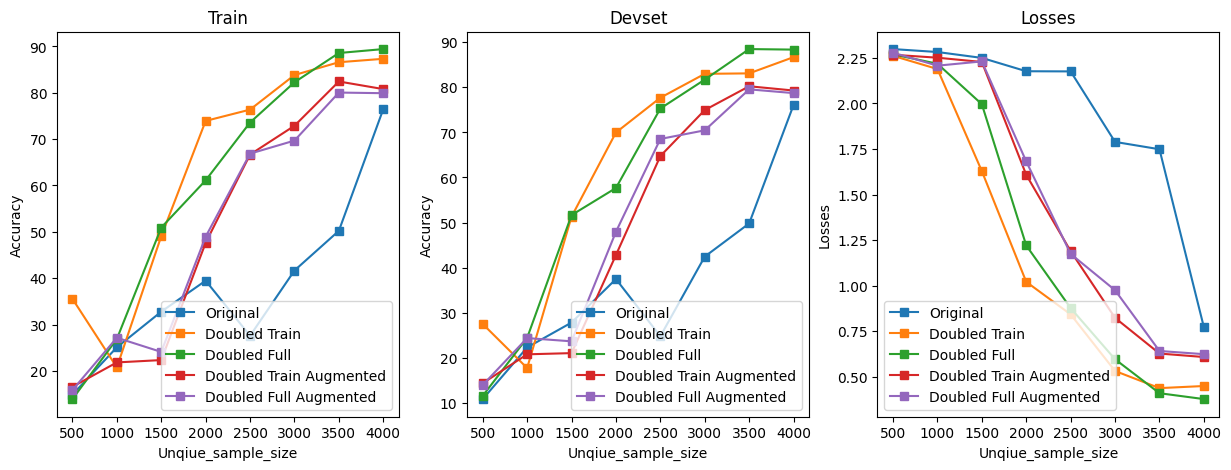

In [45]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

titles = ['Train', 'Devset', 'Losses']
yaxlabels = ['Accuracy', 'Accuracy', 'Losses']

for i in range(3):
  # plot the lines
  ax[i].plot(sample_sizes, results_single[:,i].detach(), 's-', label='Original')
  ax[i].plot(sample_sizes, results_double_train[:,i].detach(), 's-', label='Doubled Train')
  ax[i].plot(sample_sizes, results_double_full[:,i].detach(), 's-', label='Doubled Full')
  ax[i].plot(sample_sizes, results_double_train_augment[:,i].detach(), 's-', label='Doubled Train Augmented')
  ax[i].plot(sample_sizes, results_double_full_augment[:,i].detach(), 's-', label='Doubled Full Augmented')

  ax[i].set_ylabel(yaxlabels[i])
  ax[i].set_title(titles[i])
  ax[i].legend()
  ax[i].set_xlabel('Unqiue_sample_size')

# Conclusion

The results indicate that when the number of unique samples is limited, the baseline model trained on the original dataset exhibits reduced performance due to insufficient training data. This finding confirms that oversampling and data augmentation techniques are particularly beneficial in low-data regimes, where they enhance model generalization and stability. As the dataset size increases, however, these advantages gradually diminish, and the performance differences between configurations become negligible.

Moreover, doubling only the training set or the entire dataset yields comparable outcomes, suggesting that both approaches contribute similarly to improving model performance under constrained data conditions.